## Project Purpose
I wanted to learn more about the field of behavioral analytics, which I believe to be an interesting and promising field at the intersection of behavioral science and data science. Cohort analysis seemed like a good place to start.

Cohort analysis is a subset of behavioral analytics that takes data from a given platform and breaks users into related groups for analysis. There groups, or cohorts, usually share similar characteristics within a given time frame.

Cohort analysis can be valuable because it separates growth and engagement metrics since growth can mask engagement problems. Lack of activity in older users can be masked by growth from new users.

## About the Data
I used the “Online Retail Data Set” from the UCI Machine Learning Repository. This is a data set containing all the transaction between 1/12/2010 and 9/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The data has 8 columns:
1. InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
2. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
3. Description: Product (item) name. Nominal.
4. Quantity: The quantities of each product (item) per transaction. Numeric.
5. InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
6. UnitPrice: Unit price. Numeric, Product price per unit in sterling.
7. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
8. Country: Country name. Nominal, the name of the country where each customer resides.


## Steps Taken
1. Explore and clean dataset
2. Create 3 cohorts and conduct a cohort analysis on each
3. Visualize the results using heatmaps
---
# Step 1) Exploring and Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
#size of data
print('rows: {}\ncolumns: {}'.format(df.shape[0],df.shape[1]))

rows: 541909
columns: 8


In [4]:
#count of missing values for each column
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

I dropped the missing CustomerID rows because there is no real way to impute these and there are still plenty of rows left for analysis.

In [5]:
df.dropna(subset=['CustomerID'],inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


# Steps 2 & 3) Cohort Analysis & Visualization

In [7]:
# Sort invoices by month and year
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
# first month a customer made a purchase
df['CohortMonth'] = df.groupby(
    'CustomerID')['InvoiceMonth'].transform('min')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
InvoiceNo       406829 non-null object
StockCode       406829 non-null object
Description     406829 non-null object
Quantity        406829 non-null int64
InvoiceDate     406829 non-null datetime64[ns]
UnitPrice       406829 non-null float64
CustomerID      406829 non-null float64
Country         406829 non-null object
InvoiceMonth    406829 non-null object
CohortMonth     406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 34.1+ MB


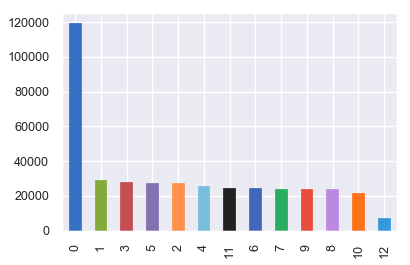

In [9]:
df['year_dif'] = df['InvoiceMonth'].dt.year - \
    df['CohortMonth'].dt.year
df['month_dif'] = df['InvoiceMonth'].dt.month - \
    df['CohortMonth'].dt.month
df['CohortIndex'] = df['year_dif'] * 12 + df['month_dif']

df['CohortIndex'].value_counts().plot(kind='bar')

Most purchases seem to be from customers whose first order was in the same month. This means that most purchases are coming from new customers. 

### Cohort 1: User Retention Rate
To see the number of active users from each cohort, I can create a pivot table of CohortMonth and the CohortIndex.

In [10]:
# take each unique CustomerID from a given month and index
# reset_index() creates a new index for each combination of CohortMonth
# and CohortIndex so that the data is not multi-indexing
cohort1_df = df.groupby(['CohortMonth', 'CohortIndex'])[
    'CustomerID'].apply(pd.Series.nunique).reset_index()
cohort1_df.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12,0,948
1,2010-12,1,362
2,2010-12,2,317
3,2010-12,3,367
4,2010-12,4,341


In [11]:
cohort1_pivot = pd.pivot_table(cohort1_df,
                               index='CohortMonth',
                               columns='CohortIndex',
                               values='CustomerID')
cohort1_pivot

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the table, the first column shows the total number of active users during that month. Each row shows the number of people that were still buying things after having made a purchase in that month. For example, in CohortIndex 12 and month 2010-12 the 260 represents 260 out of 948 users were still buying things 12 months after 2010-12.

I divide the pivot table by the total number of new users for a given month to get the percentage of people that continue buying things each month.

In [12]:
customer_count = cohort1_pivot.iloc[:, 0]
cohort1_pivot = cohort1_pivot.divide(customer_count, axis=0)
cohort1_pivot.round(3) * 100

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All of the first column is 100% because if a user bought something that month, they are by nature a customer for that month. To visualize, I put the table into a seaborn heatmap.

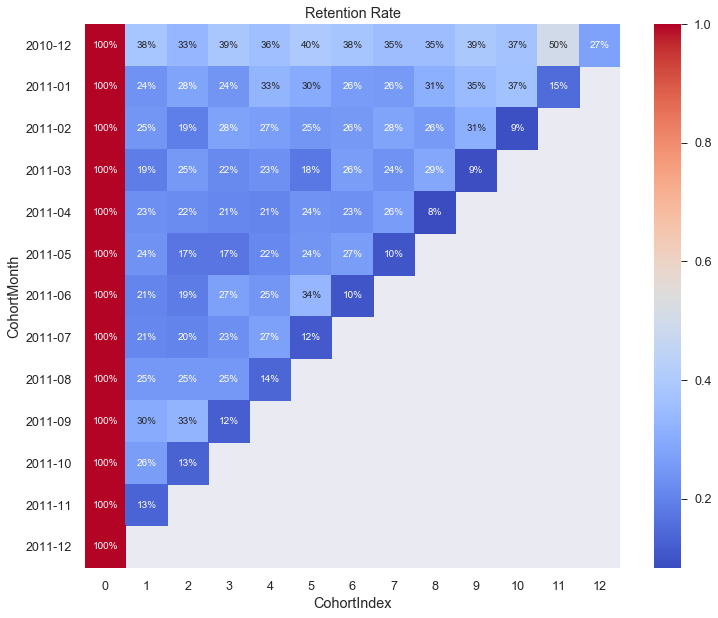

In [13]:
plt.figure(figsize=(12, 10))
plt.title('Retention Rate')

sns.heatmap(data=cohort1_pivot,
            annot=True,
            fmt='.0%',
            cmap='coolwarm')

The first cohort seems to have a much higher retention rate than other cohorts, with 27% still making purchases after a year. In addition, 50% of users in the first cohort returned 11 months later in 2011-11, an anomaly that should be investigated through looking at the marketing strategies or other differences that occured in that month.

### Cohort 2: Average Quantity Sold
Other methods exist to see how the store is performing. Another one of these metrics is quantity sold. There could be a substantial difference between the number of users retained and the quantity they buy.

In [14]:
cohort2_df = df.groupby(['CohortMonth', 'CohortIndex'])[
    'Quantity'].mean().reset_index()

cohort2_pivot = pd.pivot_table(cohort2_df,
                               index='CohortMonth',
                               columns='CohortIndex',
                               values='Quantity')
cohort2_pivot.round(1)
cohort2_pivot

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,11.037691,14.603253,14.982141,14.801090,12.943024,14.318095,15.173387,14.759559,16.660455,16.691004,17.264954,12.823263,14.776623
2011-01,10.015502,12.573579,12.343099,10.940531,12.234048,14.895373,14.226042,14.385729,11.398390,9.883069,9.090436,9.541612,NaN
2011-02,10.830223,12.081317,18.563242,11.959050,11.117223,11.411479,13.346939,12.381845,10.272146,11.945771,12.645977,NaN,NaN
2011-03,9.762443,9.924222,12.207366,9.455425,13.579228,12.313412,13.162317,12.177130,10.517494,8.880203,NaN,NaN,NaN
2011-04,9.753962,10.105226,9.420617,11.598922,11.488889,8.220785,9.680620,9.289391,7.290019,NaN,NaN,NaN,NaN
2011-05,10.866930,9.030276,13.884270,11.805435,10.900268,8.668230,10.148510,7.371571,NaN,NaN,NaN,NaN,NaN
2011-06,10.327849,13.681576,10.463847,13.275611,10.232734,9.758786,9.255627,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,9.722333,12.700952,7.142646,7.844268,6.013594,7.013233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,9.890294,5.958955,5.345404,5.976259,6.980110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And now into visualized form:

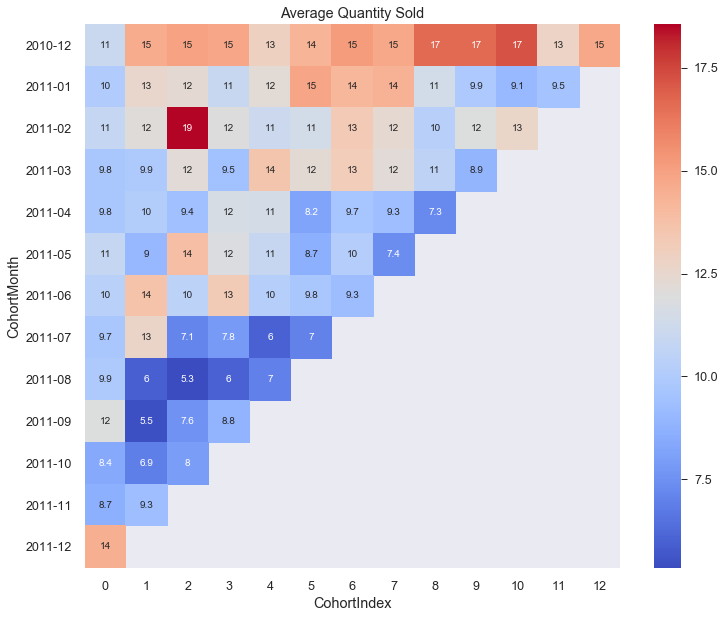

In [15]:
plt.figure(figsize=(12, 10))
plt.title('Average Quantity Sold')

sns.heatmap(data=cohort2_pivot,
            annot=True,
            cmap='coolwarm')

Over time it seems that each cohort tends to buy a lower quantity over time. It makes sense that the top row buys the most as they are early adopters, but more investigation is needed as to the cause of the overall decline.

### Cohort 3: Average Sales
Lastly, user retention and average quantity sold don't cover the full picture of the store's success. Sales is needed as well because people could be buying less but more expensive items and vice versa. The process for the cohort analysis is the same across all 3 of the cohort analyses.

In [16]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

cohort3_df = df.groupby(['CohortMonth', 'CohortIndex'])[
    'Sales'].mean().reset_index()

cohort3_pivot = pd.pivot_table(cohort3_df,
                               index='CohortMonth',
                               columns='CohortIndex',
                               values='Sales')
cohort3_pivot.round(1)
cohort3_pivot

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,20.655643,24.962459,25.139521,24.978069,19.909629,25.480250,26.451463,25.372125,25.980501,31.138593,30.557476,22.210825,24.674713
2011-01,18.444190,23.481835,20.268516,17.509983,21.525447,25.403550,24.381424,24.532572,18.719978,20.135516,18.672869,18.395317,NaN
2011-02,17.014267,16.975981,19.337248,18.776552,16.080564,15.117578,21.616925,20.945285,17.467683,20.649679,21.532575,NaN,NaN
2011-03,17.032560,17.850609,21.494776,16.957128,19.195390,18.051934,21.674036,17.294151,15.438267,11.423635,NaN,NaN,NaN
2011-04,16.361236,20.154028,18.757005,18.392671,18.642681,14.201767,14.585959,15.300126,11.849341,NaN,NaN,NaN,NaN
2011-05,19.033800,15.729252,21.209730,19.444446,17.798882,14.051821,16.136639,13.253142,NaN,NaN,NaN,NaN,NaN
2011-06,16.370579,14.504100,18.954229,19.778605,14.994626,15.880308,12.742138,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,13.113629,21.192895,11.378943,12.417094,10.510636,11.448318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,16.104983,11.892102,11.511685,14.361514,15.627878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


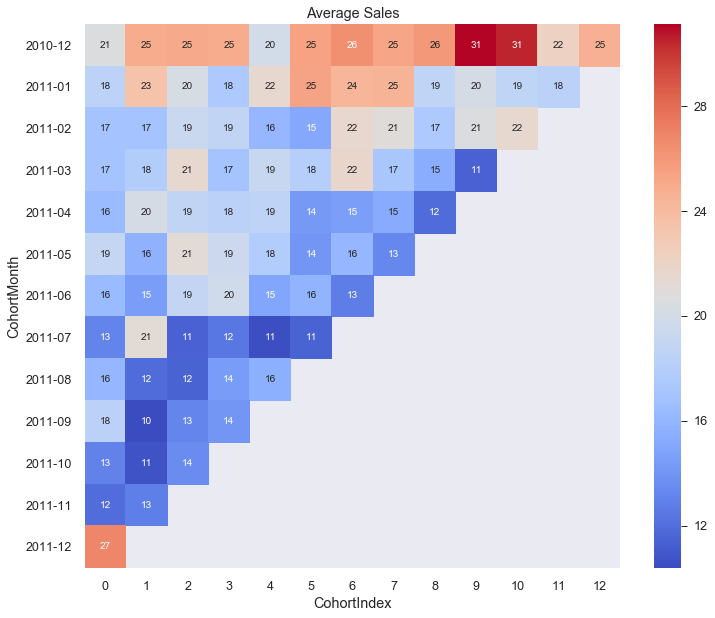

In [17]:
plt.figure(figsize=(12, 10))
plt.title('Average Sales')

sns.heatmap(data=cohort3_pivot,
            annot=True,
            cmap='coolwarm')

It seems that the average sales seems to follow the overall trend of quantity. This means that the overall decrease in quantity sold over later cohorts is most likely not due to sold items being more expensive on average.

# Conclusion
In this post, I demonstated an application of cohort analysis. It is a simple and effective tool for tracking the behavior of different groups of users. It is also highly versatile as you can look at many different time frames and different metrics for analysis. Overall, it is useful for understanding user behavior better to drive smarter decisions for a given product or service.